<a href="https://colab.research.google.com/github/fpsomad/fpsomad/blob/main/Darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# εισαγωγή βιβλιοθηκών
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [44]:
# εισαγωγή συνόλου δεδομένων
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv', low_memory = False)
data.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68580 entries, 0 to 68579
Data columns (total 83 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Src_IP                      68580 non-null  object 
 1   Src_Port                    68580 non-null  int64  
 2   Dst_IP                      68580 non-null  object 
 3   Dst_Port                    68580 non-null  int64  
 4   Protocol                    68580 non-null  int64  
 5   Flow_Duration               68580 non-null  int64  
 6   Total_Fwd_Packet            68580 non-null  int64  
 7   Total_Bwd_packets           68580 non-null  int64  
 8   Total_Length_of_Fwd_Packet  68580 non-null  int64  
 9   Total_Length_of_Bwd_Packet  68580 non-null  int64  
 10  Fwd_Packet_Length_Max       68580 non-null  int64  
 11  Fwd_Packet_Length_Min       68580 non-null  int64  
 12  Fwd_Packet_Length_Mean      68580 non-null  float64
 13  Fwd_Packet_Length_Std       685

In [45]:
# έλεγχος του συνόλου δεδομένων για κενές ή ελλείπουσες τιμές
data.isnull().sum()


Src_IP      0
Src_Port    0
Dst_IP      0
Dst_Port    0
Protocol    0
           ..
Idle_Std    0
Idle_Max    0
Idle_Min    0
Label-1     0
Label-2     0
Length: 83, dtype: int64

In [46]:
# ενοποίηση ονομασιών υπηρεσιών DarkNet
data['Label-2'] = data['Label-2'].replace(['AUDIO-STREAMING', 'Video-streaming', 'File-transfer'], ['Audio-Streaming', 'Video-Streaming','File-Transfer'])
data['Label-2'].unique()
data.groupby(data['Label-2']).size()

Label-2
Audio-Streaming     7539
Browsing            5192
Chat               11478
Email               6145
File-Transfer      11182
P2P                13711
VOIP                3566
Video-Streaming     9767
dtype: int64

In [47]:
# ορισμός κλάσης για ταξινόμηση κίνησης "Class: 0 (normal)  1 (DarkNet)"
conditions = [
    (data['Label-1'] == 'Non-Tor'),
    (data['Label-1'] == 'NonVPN'),
    (data['Label-1'] == 'Tor'),
    (data['Label-1'] == 'VPN')]
values = [0,0,1,1]
data['Class'] = np.select(conditions, values)
data.groupby(data['Class']).size()



Class
0    53671
1    14909
dtype: int64

([<matplotlib.patches.Wedge at 0x7fd1f54174f0>,
 [Text(-0.8532727834197007, 0.694208583262406, 'Normal'),
  Text(0.8532728159179485, -0.6942085433178239, 'DarkNet')],
 [Text(-0.4654215182289276, 0.37865922723403955, '78%'),
  Text(0.46542153595524455, -0.3786592054460857, '22%')])

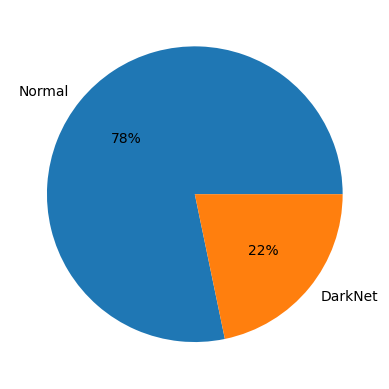

In [48]:
#γραφική απεικόνιση δεδομένων με βάση το άν η κίνηση είναι κανονική ή προέρχεται από το σκοτεινό διαδίκτυο.

type_classify=['Normal', 'DarkNet']
count_classify=[53671,14909]
plt.pie(count_classify, labels=type_classify, autopct='%0.f%%')


In [49]:
# αφαίρεση μη αριθμητικών μεταβλητών
data = data.drop(['Src_IP','Src_Port', 'Dst_IP','Dst_Port','Protocol', 'Flow_Bytes/s', 'Label-1', 'Label-2'], axis = 1)
data.head()

,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Class
0,229,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
1,407,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
2,431,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
3,359,1,1,0,0,0,0,0.000000,0.000000,0,...,20,0,0,0,0,0,0.000,0,0,0
4,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,...,20,0,0,0,0,1437760000000000,3117718.131,1437760000000000,1437760000000000,0


In [50]:
# ανακάτεμα συνόλου δεδομένων
data = data.sample(frac=1)
data.head()

,Flow_Duration,Total_Fwd_Packet,Total_Bwd_packets,Total_Length_of_Fwd_Packet,Total_Length_of_Bwd_Packet,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,...,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Class
13242,412414,2,0,44,0,22,22,22.000,0.000000,0,...,8,0,0,0,0,0,0.00,0,0,0
6517,113925009,24,24,9231,5857,543,0,384.625,252.117953,1057,...,20,0,0,0,0,1456340000000000,28139177.05,1456340000000000,1456340000000000,1
59261,345,1,1,34,141,34,34,34.000,0.000000,141,...,8,0,0,0,0,0,0.00,0,0,0
27063,44873399,1,2,0,0,0,0,0.000,0.000000,0,...,20,0,0,0,0,44871351,0.00,44871351,44871351,0
20717,115940476,60,0,3000,0,50,50,50.000,0.000000,0,...,8,0,0,0,0,1432570000000000,33907706.92,1432570000000000,1432570000000000,0


In [51]:
# αφαίρεση τιμών ΝαΝ
data = data[np.isfinite(data).all(1)]


In [52]:
# ορισμός Χ και Υ
X = data.drop('Class', axis=1)
y = data['Class']
X.shape, y.shape


((68531, 75), (68531,))

In [53]:
# τμηματοποίηση συνόλου δεδομένων 80% για εκπαίδευση, 20% για έλεγχο
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((54824, 75), (13707, 75), (54824,), (13707,))

In [54]:
#κλιμάκωση αριθμητικών δεδομένων εκπαίδευσης

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)




In [55]:
# κλιμάκωση αριθμητικών δεδομένων ελέγχου

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)


In [56]:
# εφαρμογή αλγορίθμου Decision Tree

tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(X_train_scaled, y_train)

y_train_tree = tree.predict(X_train_scaled)
y_test_tree = tree.predict(X_test_scaled)

acc_train_tree = accuracy_score(y_train,y_train_tree)
acc_test_tree = accuracy_score(y_test,y_test_tree)

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))



Decision Tree: Accuracy on training Data: 0.938
Decision Tree: Accuracy on test Data: 0.860


In [57]:
# εφαρμογή αλγορίθμου Random Forest

forest = RandomForestClassifier(max_depth=5)
forest.fit(X_train_scaled, y_train)

y_train_forest = forest.predict(X_train_scaled)
y_test_forest = forest.predict(X_test_scaled)

acc_train_forest = accuracy_score(y_train,y_train_forest)
acc_test_forest = accuracy_score(y_test,y_test_forest)

print("Random forest: Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random forest: Accuracy on test Data: {:.3f}".format(acc_test_forest))



Random forest: Accuracy on training Data: 0.907
Random forest: Accuracy on test Data: 0.856


In [58]:
# εφαρμογή αλγορίθμου Multilayer Perceptrons (MLP)

mlp = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100,100,100]))
mlp.fit(X_train_scaled, y_train)

y_train_mlp = mlp.predict(X_train_scaled)
y_test_mlp = mlp.predict(X_test_scaled)

acc_train_mlp = accuracy_score(y_train,y_train_mlp)
acc_test_mlp = accuracy_score(y_test,y_test_mlp)

print("Multilayer Perceptrons: Accuracy on training Data: {:.3f}".format(acc_train_mlp))
print("Multilayer Perceptrons: Accuracy on test Data: {:.3f}".format(acc_test_mlp))



Multilayer Perceptrons: Accuracy on training Data: 0.956
Multilayer Perceptrons: Accuracy on test Data: 0.911


In [63]:
# εφαρμογή αλγορίθμου Gradient Boosting Classifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25, max_features=2, max_depth=2, random_state=0)
gbc.fit(X_train_scaled, y_train)

y_train_gbc = gbc.predict(X_train_scaled)
y_test_gbc = gbc.predict(X_test_scaled)

acc_train_gbc = accuracy_score(y_train,y_train_gbc)
acc_test_gbc = accuracy_score(y_test,y_test_gbc)

print("Gradient Boosting Classifier: Accuracy on training Data: {:.3f}".format(acc_train_gbc))
print("Gradient Boosting Classifier: Accuracy on test Data: {:.3f}".format(acc_test_gbc))


Gradient Boosting Classifier: Accuracy on training Data: 0.932
Gradient Boosting Classifier: Accuracy on test Data: 0.830


In [ ]:
# εφαρμογή αλγορίθμων ταξινόμησης (Classifiers)

# ορισμός αλγορίθμων
classifiers = [ DecisionTreeClassifier(), RandomForestClassifier(), MLPClassifier(), GradientBoostingClassifier()]

# αξιολόγηση και σύγκριση αλγορίθμων
results_train = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
results_test = {'Classifier': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for clf in classifiers:
    clf_name = clf.__class__.__name__

    # εκπαίδευση αλγορίθμου
    clf.fit(X_train_scaled, y_train)

    # πρόβλεψη αλγορίθμου
    y_train_pred = clf.predict(X_train_scaled)
    y_test_pred = clf.predict(X_test_scaled)

    # Calculate evaluation metrics
    acc = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred, average='weighted')
    recall = recall_score(y_train, y_train_pred, average='weighted')
    f1 = f1_score(y_train, y_train_pred, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(y_train, y_train_pred)

    # Display results
    print(f"\n{clf_name} Metrics:")
    print(f"Accuracy: {acc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Confusion Matrix:")


